<a href="https://colab.research.google.com/github/shrybhrdwj/Brain_Tumor/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

shrybhrdwj_brainmriimage54_path = kagglehub.dataset_download('shrybhrdwj/brainmriimage54')

print('Data source import complete.')


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733204170.388680     105 service.cc:145] XLA service 0x7d83b0001ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733204170.388754     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733204170.388759     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/179 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.2109 - loss: 2.4350   

I0000 00:00:1733204197.140466     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 165s 690ms/step - accuracy: 0.2518 - loss: 2.2901 - val_accuracy: 0.2288 - val_loss: 1.4017 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 384ms/step - accuracy: 0.2592 - loss: 2.1255 - val_accuracy: 0.2334 - val_loss: 1.4114 - learning_rate: 1.0000e-04
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 388ms/step - accuracy: 0.2478 - loss: 2.0296 - val_accuracy: 0.3089 - val_loss: 1.3972 - learning_rate: 1.0000e-04
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 390ms/step - accuracy: 0.2531 - loss: 1.9512 - val_accuracy: 0.3089 - val_loss: 1.3815 - learning_rate: 1.0000e-04
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 396ms/step - accuracy: 0.2442 - loss: 1.8927 - val_accuracy: 0.3089 - val_loss: 1.3919 - learning_rate: 1.0000e-04
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 386ms/step - accuracy: 0.2437 - loss: 1.8096 - val_accuracy: 0.3089 - val_loss: 1.3841 - learning_rate: 1.0000e-04
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 395ms/step -

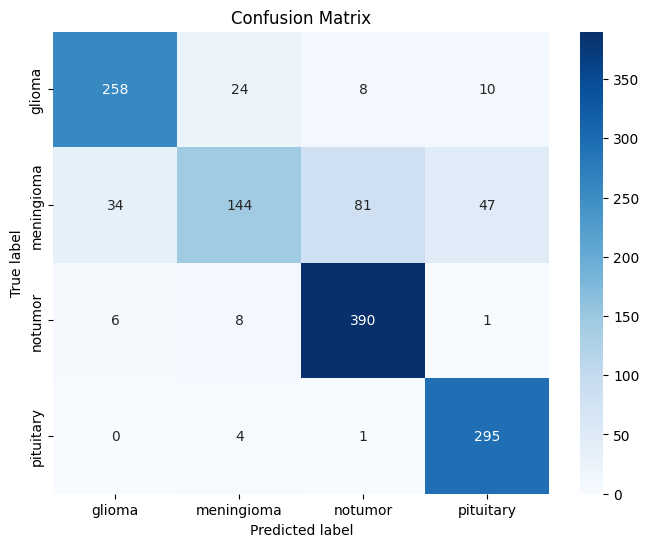

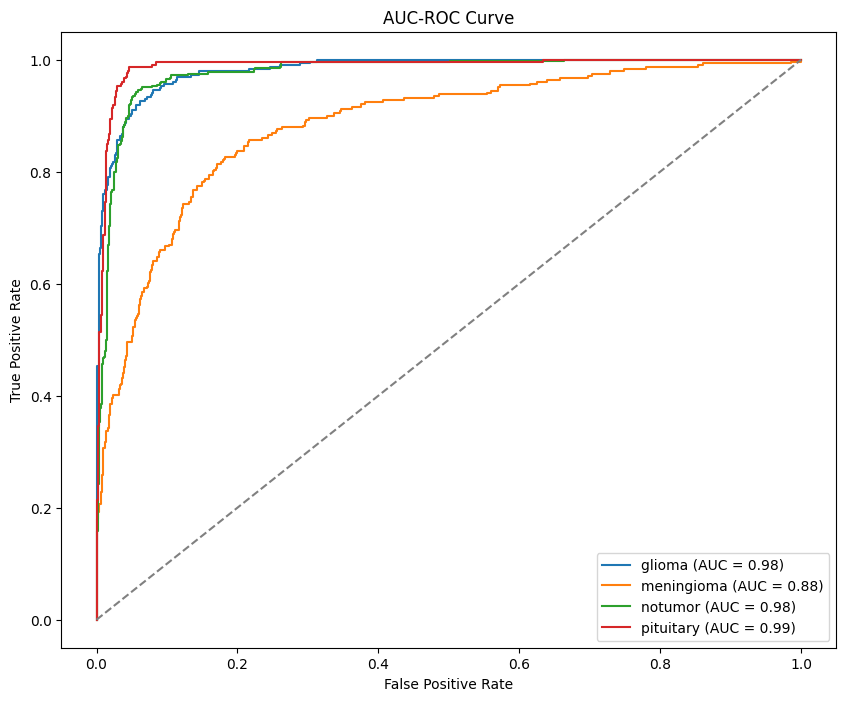

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer

# Step 1: Set Dataset Paths
dataset_path = '/kaggle/input/brainmriimage54'
training_dir = os.path.join(dataset_path, 'Training')
testing_dir = os.path.join(dataset_path, 'Testing')

# Step 2: Data Preprocessing and Augmentation
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    directory=training_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=testing_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order for metrics
)

# Compute Class Weights
class_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights_dict = dict(enumerate(class_weights))

# Step 3: Load EfficientNet Model with Pretrained Weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add Custom Layers on Top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Step 5: Train the Model with Class Weights
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler]
)

# Fine-Tune the Model: Unfreeze More Layers
for layer in base_model.layers:
    layer.trainable = True

# Recompile Model with Lower Learning Rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-Tuning
history_fine_tune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler]
)

# Step 6: Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the Model
model.save("brain_tumor_classifier_efficientnet.h5")

# Step 7: Generate Confusion Matrix and Classification Report
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Step 8: ROC and AUC
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
y_pred_bin = predictions

# Calculate ROC and AUC for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(test_generator.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
